In [11]:
import cv2
import numpy as np
from IPython.display import display
from PIL import Image
from src.config import CONFIG_DEFAULTS as config
from src.logger import logger
from myclass import *
min_matching_threshold =  0.3
max_matching_variation = 0.41
marker_rescale_range =  (35, 100)
marker_rescale_steps =  10
apply_erode_subtract =  0


ModuleNotFoundError: No module named 'myclass'

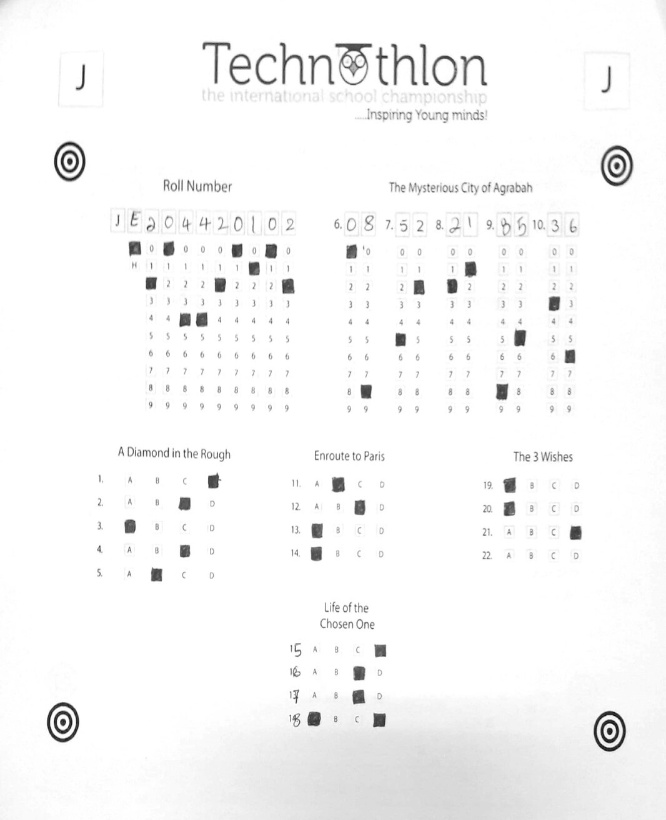

NameError: name 'normalize_util' is not defined

In [8]:
def apply_filter(image):
        
       
        image_eroded_sub = normalize_util(
            image
            if apply_erode_subtract
            else 
            (image - cv2.erode(image, kernel=np.ones((5, 5)), iterations=5))
        )
 # Quads on warped image
        quads = {}
        h1, w1 = image_eroded_sub.shape[:2]
        midh, midw = h1 // 3, w1 // 2
        origins = [[0, 0], [midw, 0], [0, midh], [midw, midh]]
        quads[0] = image_eroded_sub[0:midh, 0:midw]
        quads[1] = image_eroded_sub[0:midh, midw:w1]
        quads[2] = image_eroded_sub[midh:h1, 0:midw]
        quads[3] = image_eroded_sub[midh:h1, midw:w1]

        # Draw Quadlines
        image_eroded_sub[:, midw : midw + 2] = 255
        image_eroded_sub[midh : midh + 2, :] = 255
        # cv2.imshow("e+1",image_eroded_sub)
        display(Image.fromarray(image_eroded_sub))

        best_scale, all_max_t = getBestMatch(image_eroded_sub)
        # cv2.imshow("e+2",all_max_t)
        # if best_scale is None:
        #     # TODO: Plot and see performance of marker_rescale_range
        #     if config.outputs.show_image_level >= 1:
        #         MainOperations.show("Quads", image_eroded_sub)
        #     return None
        print(all_max_t)
        optimal_marker = resize_util_h(
            marker, u_height=int(marker.shape[0] * best_scale)
        )
      
        _h, w = optimal_marker.shape[:2]
        centres = []
        sum_t, max_t = 0, 0
        logger.info("Matching Marker:\t", end=" ")
        for k in range(0, 4):
            res = cv2.matchTemplate(quads[k], optimal_marker, cv2.TM_CCOEFF_NORMED)
            
            max_t = res.max()
            logger.info(f"Quarter{str(k + 1)}: {str(round(max_t, 3))} ", end="\t")
            # if (
            #     max_t < self.min_matching_threshold
            #     or abs(all_max_t - max_t) >= self.max_matching_variation
            # ):
            #     # Warning - code will stop in the middle. Keep Threshold low to
            #     # avoid.
            #     logger.error(
            #         args["current_file"].name,
            #         "\nError: No circle found in Quad",
            #         k + 1,
            #         "\n\t min_matching_threshold",
            #         self.min_matching_threshold,
            #         "\t max_matching_variation",
            #         self.max_matching_variation,
            #         "\t max_t",
            #         max_t,
            #         "\t all_max_t",
            #         all_max_t,
            #     )
            #     if config.outputs.show_image_level >= 1:
            #         MainOperations.show(
            #             "no_pts_" + args["current_file"].name, image_eroded_sub, 0
            #         )
            #         MainOperations.show(
            #             "res_Q" + str(k + 1) + " (" + str(max_t) + ")", res, 1
            #         )
            #     return None

            pt = np.argwhere(res == max_t)[0]
            pt = [pt[1], pt[0]]
            pt[0] += origins[k][0]
            pt[1] += origins[k][1]
            print(">>",pt)
            image = cv2.rectangle(
                image, tuple(pt), (pt[0] + w, pt[1] + _h), (150, 150, 150), 2
            )
            # cv2.imshow(str(k + 5),image)
            # display:
            image_eroded_sub = cv2.rectangle(
                image_eroded_sub,
                tuple(pt),
                (pt[0] + w, pt[1] + _h),
                (50, 50, 50) if apply_erode_subtract else (155, 155, 155),
                4,
            )
            centres.append([pt[0] + w / 2, pt[1] + _h / 2])
            sum_t += max_t
        logger.info("Optimal Scale:", best_scale)
        # analysis data
        # threshold_circles.append(sum_t / 4)

        image = four_point_transform(image, np.array(centres))
        # appendSaveImg(1,image_eroded_sub)
        # appendSaveImg(1,image_norm)
        #  append_save_img(2, image_eroded_sub)
        # Debugging image -
        # res = cv2.matchTemplate(image_eroded_sub,optimal_marker,cv2.TM_CCOEFF_NORMED)
        # res[ : , midw:midw+2] = 255
        # res[ midh:midh+2, : ] = 255
        # show("Markers Matching",res)
        # if config.outputs.show_image_level >= 2 and config.outputs.show_image_level < 4:
        #     image_eroded_sub = ImageUtils.resize_util_h(
        #         image_eroded_sub, image.shape[0]
        #     )
        #     image_eroded_sub[:, -5:] = 0
        #     h_stack = np.hstack((image_eroded_sub, image))
        #     MainOperations.show(
        #         "Warped: " + args["current_file"].name,
        #         ImageUtils.resize_util(
        #             h_stack, int(config.dimensions.display_width * 1.6)
        #         ),
        #         0,
        #         0,
        #         [0, 0],
        #     )
        # iterations : Tuned to 2.
        # image_eroded_sub = image_norm - cv2.erode(image_norm, kernel=np.ones((5,5)),iterations=2)
        # cv2.imshow("e+",image)
        return image


image = cv2.imread("savedimage.jpeg", cv2.IMREAD_GRAYSCALE)
display(Image.fromarray(image))
display(Image.fromarray(apply_filter( image)))